# Letter generation using latent spaces

## Introduction

In this project we will generate images of letters using a latent space representation and matrix decompositions. For this we will use the part of the  [Extended MNIST dataset](https://www.kaggle.com/datasets/crawford/emnist) that contains letters from the english alphabet.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.neighbors import KDTree

## Data loading and EDA

Let us load the data from a csv and inspect it in order to get a solid understanding of what it means, so we can work with it.

In [2]:
train = pd.read_csv('emnist-letters-train.csv', header=None)
test = pd.read_csv('emnist-letters-test.csv', header=None)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88800 entries, 0 to 88799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 531.8 MB


In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(np.sort(train[0].unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


In [6]:
train.drop(columns=0).to_numpy().min(), train.drop(columns=0).to_numpy().max()

(0, 255)

After running the abow code cells, we can see that the csv files contain 785 columns. Every column is sparse but the first one. The first column contains the labels with values ranging from 1 to 26 which represent the letters from the english alphabet. THe other 784 columns contain a flattened grayscale image that is 28x28(=784). The values of the images range from 0 to 255 which is a standard way of storing images.

In [7]:
x_train = train.drop(columns=0).to_numpy()
y_train = train[0].to_numpy()
x_test = test.drop(columns=0).to_numpy()
y_test = test[0].to_numpy()
del train
del test

The following function will help us easily visualize multiple images on a grid.

In [8]:
def viz_grid(grid_shape, images):
    assert grid_shape[0] * grid_shape[1] >= len(images)
    fig, ax = plt.subplots(*grid_shape)
    for i in range(grid_shape[0] * grid_shape[1]):
        row_idx = i // grid_shape[1]
        col_idx = i % grid_shape[1]
        if i < len(images):
            ax[row_idx, col_idx].imshow(images[i].reshape(28, 28).transpose(), cmap='gist_yarg')
        else:
            ax[row_idx, col_idx].imshow(np.zeros((28, 28)), cmap='gist_yarg')
        ax[row_idx, col_idx].set_xticks([])
        ax[row_idx, col_idx].set_yticks([])
    plt.show()

Now that we have a tool to visualize images, let us take a look at the first 20 images of the training and test sets and their labels.

Image (1):


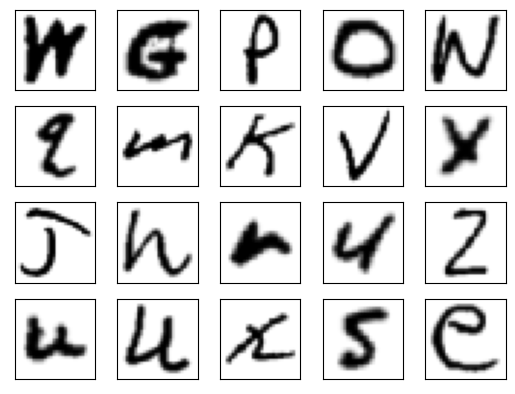

[['w' 'g' 'p' 'o' 'w']
 ['q' 'm' 'k' 'v' 'x']
 ['j' 'n' 'r' 'u' 'z']
 ['u' 'u' 'x' 's' 'e']]
Image (2):


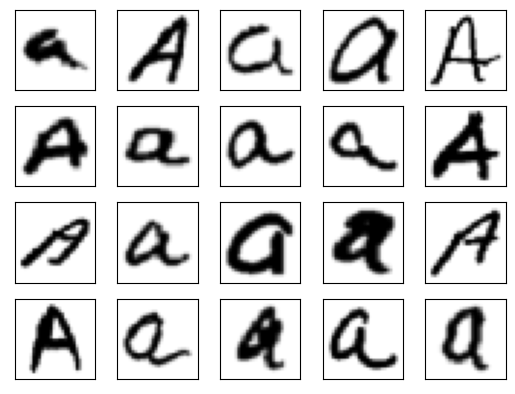

[['a' 'a' 'a' 'a' 'a']
 ['a' 'a' 'a' 'a' 'a']
 ['a' 'a' 'a' 'a' 'a']
 ['a' 'a' 'a' 'a' 'a']]


In [9]:
all_letters = np.array([
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
    'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
    'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
])
print('Image (1):')
viz_grid((4, 5), x_train[:20])
print(all_letters[y_train[:20] - 1].reshape(4, 5))
print('Image (2):')
viz_grid((4, 5), x_test[:20])
print(all_letters[y_test[:20] - 1].reshape(4, 5))

## Model building

The image generator uses a decomposer algorithm like NMF or SVD to convert the images into latent space representation and using a KDTree it can query from this latent space in order to generate new images. The basic idea is that we can create base images that we can later use to mix together and reconstruct the original images, or modify the amount of mixture a bit to generate a brand-new image that is not present in the original dataset. Since we can convert any image into latent space using the base images, we can even ask the generator to generate images that look like the reference image that we gave it.

In [10]:
class ImageGenerator:
    def __init__(self, decomposer, images, labels, img_shape):
        self._x = images.reshape(images.shape[0], -1)
        self._y = labels
        self._core = decomposer.fit(self._x)
        self._num_components = len(self._core.components_)
        self._img_shape = img_shape
        self._all_letters = np.array([
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
            'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
            'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
            'y', 'z'
        ])
        self._kdtree = KDTree(self._core.transform(self._x), leaf_size=40, metric='minkowski')

    def label2letter(self, labels):
        if type(labels) is list:
            labels = np.array(labels)
        return self._all_letters[labels - 1]

    def letter2label(self, letters):
        labels = []
        for l in letters:
            labels.append(np.where(self._all_letters == l)[0][0] + 1)
        if len(labels) == 1:
            return labels[0]
        return np.array(labels)

    def get_bases(self, flat=False):
        return self._core.components_.reshape(self._num_components, *(self._img_shape if not flat else -1))

    def gen_averages(self, letters, flat=False):
        tmp_images = []
        for letter in letters:
            tmp_images.append(
                (
                    self._core.components_.transpose() @ self._core.transform(self._x[self._y == self.letter2label(letter)]).mean(0)
                ).reshape(self._img_shape if not flat else -1)
            )
        return np.array(tmp_images)

    def gen_from_letters(self, letters, tolerance, seed=None, flat=False):
        assert tolerance > 0 and isinstance(tolerance, int)

        images = []
        for l in self.letter2label(letters):
            correct = self._x[self._y == l]
            if seed is not None:
                np.random.seed(seed)
            images.append(correct[np.random.choice(len(correct))])
        images = np.array(images)

        ind = self._kdtree.query(self._core.transform(images), k=tolerance, return_distance=False)
        img = np.asarray(self._kdtree.data)[ind].mean(1) @ self._core.components_

        img[img < 0] = 0
        img[img > 255] = 255

        return img.reshape(len(images), *self._img_shape if not flat else -1)

    def gen_from_images(self, images, tolerance, flat=False):
        assert tolerance > 0 and isinstance(tolerance, int)

        ind = self._kdtree.query(self._core.transform(images), k=tolerance, return_distance=False)
        img = np.asarray(self._kdtree.data)[ind].mean(1) @ self._core.components_

        img[img < 0] = 0
        img[img > 255] = 255

        return img.reshape(len(images), *self._img_shape if not flat else -1)

### Using the NMF algorithm

In [11]:
nmf_generator = ImageGenerator(NMF(n_components=64, random_state=1), x_train, y_train, (28, 28))

Image (3):


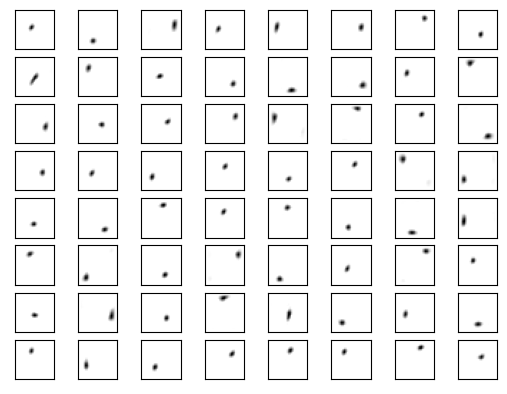

Image (4):


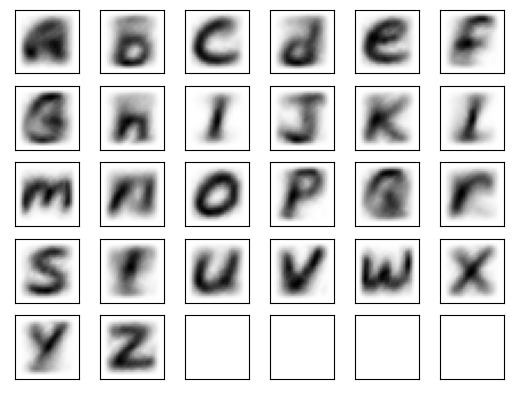

Image (5):


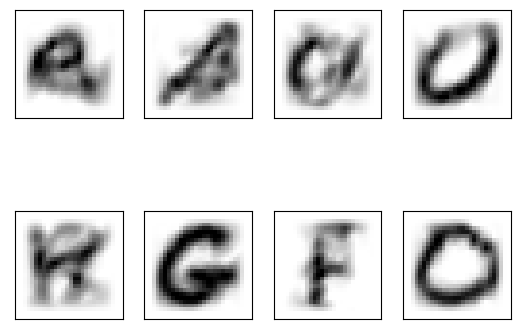

Image (6):


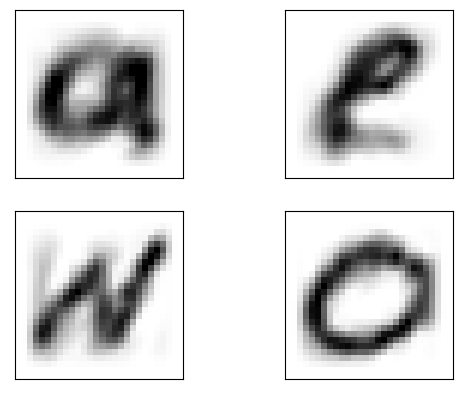

In [12]:
print('Image (3):')
viz_grid((8, 8), nmf_generator.get_bases())

print('Image (4):')
viz_grid((5, 6), nmf_generator.gen_averages(nmf_generator._all_letters))

print('Image (5):')
viz_grid((2, 4), nmf_generator.gen_from_images(np.concatenate([x_test[:4], x_train[:4]]), tolerance=5))

print('Image (6):')
viz_grid((2, 2), nmf_generator.gen_from_letters(['a', 'e', 'w', 'o'], tolerance=5, seed=2))

### Using the SVD algorithm

In [13]:
tsvd_generator = ImageGenerator(TruncatedSVD(n_components=64, random_state=1), x_train, y_train, (28, 28))

Image (7):


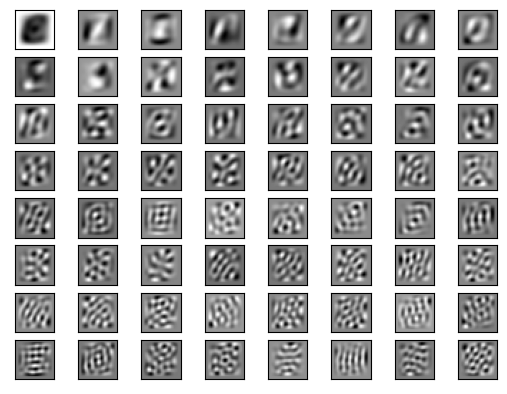

Image (8):


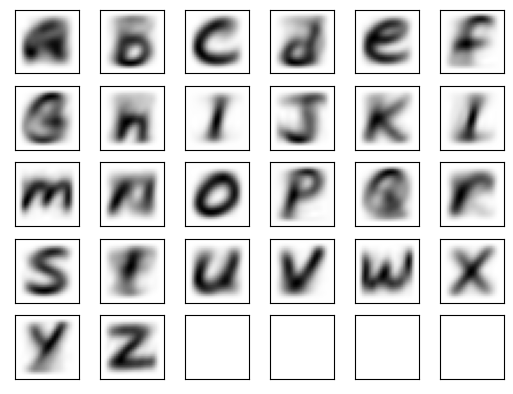

Image (9):


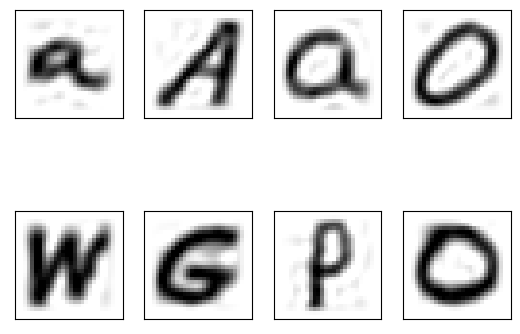

Image (10):


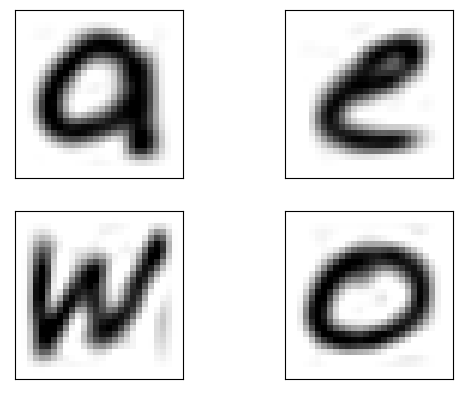

In [14]:
print('Image (7):')
viz_grid((8, 8), tsvd_generator.get_bases())

print('Image (8):')
viz_grid((5, 6), tsvd_generator.gen_averages(tsvd_generator._all_letters))

print('Image (9):')
viz_grid((2, 4), tsvd_generator.gen_from_images(np.concatenate([x_test[:4], x_train[:4]]), tolerance=3))

print('Image (10):')
viz_grid((2, 2), tsvd_generator.gen_from_letters(['a', 'e', 'w', 'o'], tolerance=5, seed=2))

## Comparison of the two algorithms

From the abow images (3) and (7), we can see that NMF and SVD create vastly different base images. This is probably due to the fact that NMF only contains non-negative values. This means that "it can only add but not subtract" while negative values are allowed in the SVD base images so "it can subtract". This results in very basic additive base components in the case of NMF, while the SVD base components are more like what could be imagined from frequency images from a Fourier transformation. Another observation is that NMF produces sparce bases. In my opinion this is because the solver of the sklearn library uses L1 regularization which penalises according to the values' distance from zero.

An interesting fact is that if we compare images (4) and (8), they are basically identical to each other even though the base images used to create them are significantly differ from each other.

Images (5) and (9) are generated images with the constraint that they have to be similar to the first 4 images taken from (1) and (2). We can start to see the differences in the power of the two methods. Clearly SVD produces better images, while the results of using NMF is much more fuzzy and blured as if the letters ere made out of fog or clouds.

In the case of images (6) and (10), where the letters were generated without the constraint of looking like a reference image, the results are a bit better with less fuzziness in the case of NMF, but the differences are still easily noticeable.

In conclusion, we can clearly say that SVD works better for this particular problem, probably due to not being constrained to using only non-negative values.

Here are some additional side-by-side comparisons of the two algorithms, on every letter of the english alphabet:

NMF:


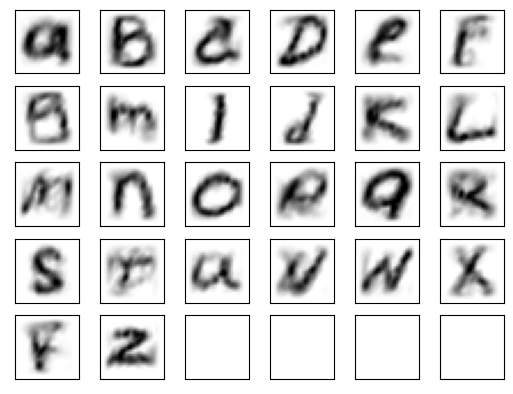

SVD:


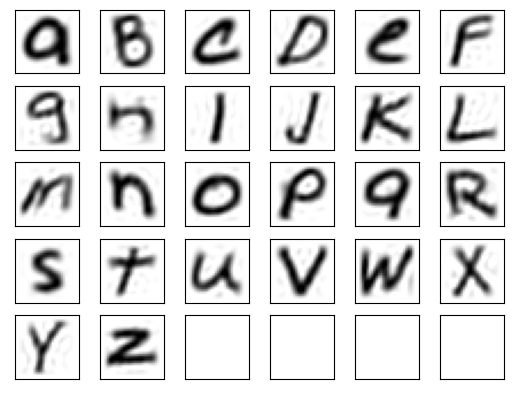

In [15]:
print('NMF:')
viz_grid((5, 6), nmf_generator.gen_from_letters(nmf_generator._all_letters, tolerance=5, seed=2))
print('SVD:')
viz_grid((5, 6), tsvd_generator.gen_from_letters(tsvd_generator._all_letters, tolerance=5, seed=2))